# Medical Image Analysis: chest X-Ray lung segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# folder = "../../../../../Downloads/scratch/"
folder = './drive/MyDrive/Colab Notebooks/scratch/'

Mounted at /content/drive


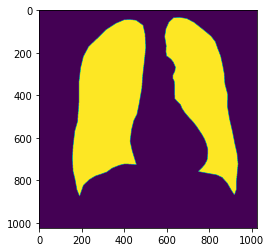

In [2]:
# reading gif images as numpy arrays
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
leftLung = imread(folder+"fold1/masks/left lung/JPCLN001.gif")
rightLung = imread(folder+"fold1/masks/right lung/JPCLN001.gif")
bothLungs = leftLung + rightLung
plt.imshow(bothLungs)

Training mask loading finished.


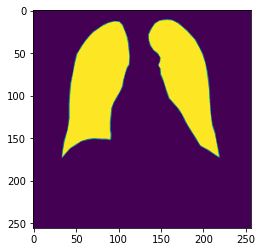

Train image loading finished.


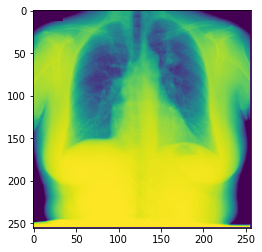

Test mask loading finished.


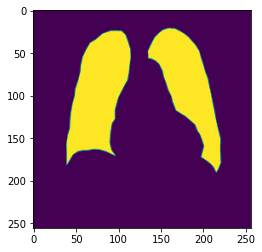

Test image loading finished.


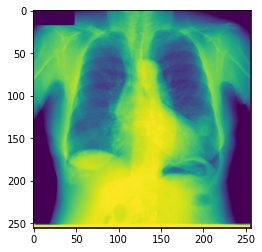

In [3]:
import os
from PIL import Image
import numpy as np

training_masks_path = folder + "fold1/masks"
test_masks_path = folder + "fold2/masks"
image_path = folder + "images/"

training_masks_left = os.listdir(f"{training_masks_path}/left lung")
training_masks_left = [mask for mask in training_masks_left if mask[-3:] != "bmp"]

test_masks_left = os.listdir(f"{test_masks_path}/left lung")
test_masks_left = [mask for mask in test_masks_left if mask[-3:] != "bmp"]


def get_joint_mask(name, path):
    correspondingImageShape = np.array(Image.open(image_path+name[:-3]+"bmp").convert('L')).shape
    left = np.array(Image.open(f"{path}/left lung/{name}").convert('L').resize(correspondingImageShape), dtype=np.float32)
    right = np.array(Image.open(f"{path}/right lung/{name}").convert('L').resize(correspondingImageShape), dtype=np.float32)
    return (left + right)

mask_array_training = np.stack([get_joint_mask(x, training_masks_path) for x in training_masks_left], 0)
print("Training mask loading finished.")
plt.figure(1)
plt.imshow(mask_array_training[0])
plt.show()
im_array_training = np.stack([np.array(Image.open(image_path+name[:-3]+"bmp").convert('L')) for name in training_masks_left], 0)
print("Train image loading finished.")
plt.figure(2)
plt.imshow(im_array_training[0])
plt.show()
mask_array_testing = np.stack([get_joint_mask(x, test_masks_path) for x in test_masks_left], 0)
print("Test mask loading finished.")
plt.figure(3)
plt.imshow(mask_array_testing[0])
plt.show()
im_array_testing = np.stack([np.array(Image.open(image_path+name[:-3]+"bmp").convert('L')) for name in test_masks_left], 0)
print("Test image loading finished.")
plt.figure(4)
plt.imshow(im_array_testing[0])
plt.show()

After loading:
(124, 256, 256)
(124, 256, 256)
After transformation:
(124, 256, 256, 1)
(124, 256, 256, 1)


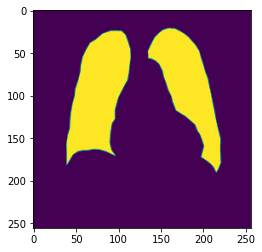

In [4]:
# what is the mask shape?
print("After loading:")
print(mask_array_training.shape)
print(im_array_training.shape)

im_array_training = np.expand_dims(im_array_training, axis=3)
mask_array_training = np.expand_dims(mask_array_training, axis=3)
mask_array_training[mask_array_training < 225.0] = 0.0
mask_array_training[mask_array_training >= 225.0] = 1.0

print("After transformation:")
print(mask_array_training.shape)
print(im_array_training.shape)

plt.figure(1)
plt.imshow(mask_array_testing[0])
plt.show()


In [5]:
test = mask_array_training[0]
print('zeros',len(test[test==0.0]))
print('ones', len(test[test==1.0]))
print('sum', len(test[test==0.0]) + len(test[test==1.0]))
print('total', test.shape[0]*test.shape[1])

zeros 51934
ones 13602
sum 65536
total 65536


In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import random_split
from torchvision.utils import make_grid

In [7]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [8]:
device = get_default_device()
print(torch.cuda.is_available())

True


In [9]:
class ImageDataset(Dataset):
    def __init__(self, data, masks, transform=None):
        self.data = data
        self.masks = masks
        self.transform = transform
        
    def __getitem__(self, index):
        image = self.data[index]
        mask = self.masks[index]
        if self.transform:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            mask = mask.permute(2, 0, 1)
        return image, mask
    
    def __len__(self):
        return len(self.data)

train_transform = A.Compose(
    [
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Normalize(
            mean=[0.0],
            std=[1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

VALIDATION_SPLIT = 0.15
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 50

dataset = ImageDataset(im_array_training, mask_array_training, train_transform)
val_size = int(VALIDATION_SPLIT * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=BATCH_SIZE,
                num_workers=2,
                pin_memory=True,
                shuffle=False)
val_loader = torch.utils.data.DataLoader(
                val_dataset,
                batch_size=BATCH_SIZE,
                num_workers=2,
                pin_memory=True,
                shuffle=False)
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [10]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_convolution = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_convolution(x)

class UpScale(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConvolution(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class DownScale(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConvolution(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [11]:
class UNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(UNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.inc = DoubleConvolution(input_dim, 64)
        self.down1 = DownScale(64, 128)
        self.down2 = DownScale(128, 256)
        self.down3 = DownScale(256, 512)
        self.down4 = DownScale(512, 1024 )
        self.up1 = UpScale(1024, 512)
        self.up2 = UpScale(512, 256)
        self.up3 = UpScale(256, 128)
        self.up4 = UpScale(128, 64)
        self.outc = OutConv(64, output_dim)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def training_step(self, batch, criterion):
        data, masks = batch
        with torch.cuda.amp.autocast():
            pred = self(data)
            loss = criterion(pred, masks)
        return loss

    def dice_coefficient(self, y_true, y_pred): 
        y_pred_f = torch.flatten(y_pred)
        y_true_f = torch.flatten(y_true)
        intersection = torch.sum(y_pred_f * y_true_f)
        return (2. * intersection) / (torch.sum(y_pred_f + y_true_f) + 1e-8)
        
    def validation_step(self, batch, loader_len, criterion):
        data, labels = batch
        pred = self(data)
        loss = criterion(pred, labels)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()
        num_correct = (pred == labels).sum()
        num_pixels = torch.numel(pred)
        dice_score = self.dice_coefficient(labels, pred) / loader_len
        return {'val_loss': loss, 'val_acc': num_correct/num_pixels*100, 'dice': dice_score}
    
    def validation_epoch_end(self, outputs):
        batch_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        batch_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        batch_dice = torch.stack([x['dice'] for x in outputs]).mean()
        return {'val_loss': batch_loss.item(), 'val_acc': batch_acc.item(), 'dice': batch_dice.item()}

    def epoch_end(self, epoch, result):
            print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, dice_score: {:.4f}".format(
                epoch, result['train_loss'], result['val_loss'], result['val_acc'], result['dice']))
    

In [12]:
from sklearn.model_selection import KFold

@torch.no_grad()
def evaluate(model, val_loader, criterion):
    model.eval()
    outputs = [model.validation_step(batch, len(val_loader), criterion) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(model, dataset, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()
    gradScaler = torch.cuda.amp.GradScaler()
    for epoch in range(EPOCHS):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch, criterion)
            train_losses.append(loss)
            gradScaler.scale(loss).backward()
            gradScaler.step(optimizer)
            gradScaler.update()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader, criterion)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)    
        history.append(result)
    return history

In [13]:
model = to_device(UNet(1,1), device)
opt_func = torch.optim.Adam
history = fit(model, dataset, opt_func)

Epoch [0], train_loss: 0.6259, val_loss: 0.6885, val_acc: 73.1091, dice_score: 0.4210
Epoch [1], train_loss: 0.4568, val_loss: 0.6669, val_acc: 66.0400, dice_score: 0.0607
Epoch [2], train_loss: 0.3659, val_loss: 0.6455, val_acc: 77.3772, dice_score: 0.5964
Epoch [3], train_loss: 0.3076, val_loss: 0.6179, val_acc: 79.4821, dice_score: 0.7125
Epoch [4], train_loss: 0.2730, val_loss: 0.6080, val_acc: 73.8434, dice_score: 0.6853
Epoch [5], train_loss: 0.2547, val_loss: 0.5716, val_acc: 74.4308, dice_score: 0.6960
Epoch [6], train_loss: 0.2417, val_loss: 0.4020, val_acc: 87.7846, dice_score: 0.8068
Epoch [7], train_loss: 0.2253, val_loss: 0.3654, val_acc: 88.2170, dice_score: 0.7923
Epoch [8], train_loss: 0.2173, val_loss: 0.3973, val_acc: 83.8493, dice_score: 0.6642
Epoch [9], train_loss: 0.2099, val_loss: 0.3197, val_acc: 89.9966, dice_score: 0.8129
Epoch [10], train_loss: 0.2005, val_loss: 0.2571, val_acc: 94.5833, dice_score: 0.9079
Epoch [11], train_loss: 0.1965, val_loss: 0.2376, val

In [14]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    plt.show()

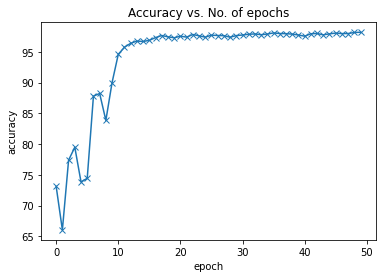

In [15]:
plot_accuracies(history)

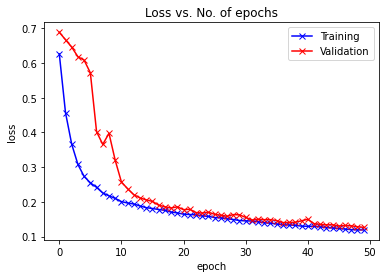

In [16]:
plot_losses(history)

In [17]:
torch.save(model.state_dict(), folder+"LatestAccurateLungSegmentationModelV2.pth")

In [18]:
# model = UNet(1,1)
# model.load_state_dict(torch.load(folder+"LatestAccurateLungSegmentationModel.pth"))
# model.eval()

In [19]:
def predict(loader, model):
    folder = './predictions'
    os.mkdir(folder)
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/Pred_{idx}.png"
        )
        torchvision.utils.save_image(y, f"{folder}/GT{idx}.png")

    model.train()

In [20]:
im_array_testing = np.expand_dims(im_array_testing, axis=3)
mask_array_testing = np.expand_dims(mask_array_testing, axis=3)
mask_array_testing[mask_array_testing < 225.0] = 0.0
mask_array_testing[mask_array_testing >= 225.0] = 1.0
test_dataset = ImageDataset(im_array_testing, mask_array_testing, val_transform)

test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        num_workers=0,
        pin_memory=True,
        shuffle=False)
test_loader = DeviceDataLoader(test_loader, device)

In [21]:
predict(test_loader, model)

In [22]:
def dice_coefficient(y_true, y_pred): 
    y_pred_f = torch.flatten(y_pred)
    y_true_f = torch.flatten(y_true)
    intersection = torch.sum(y_pred_f * y_true_f)
    return (2. * intersection) / (torch.sum(y_pred_f + y_true_f) + 1e-8)

def getDiceScores(loader, model):
    model.eval()
    dice_scores=[]
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            dice_score = dice_coefficient(y, preds)
        dice_score = float(dice_score.detach().cpu().numpy())
        dice_scores.append(dice_score)
        print(dice_score)
    avg = np.mean(dice_scores)
    print(f"Average score: {avg}")
    model.train()
    return dice_scores, avg

In [23]:
scores, avg = getDiceScores(test_loader, model)

scores.append(avg)
csv_df = {
    'Mask': [x for x in test_masks_left].append("Total average:"),
    'Score': scores
}

import pandas as pd
df = pd.DataFrame(csv_df)
df.to_csv('dice_scores_test.csv')

0.9469833970069885
0.9790117144584656
0.9727160334587097
0.9829812049865723
0.9591362476348877
0.9767391681671143
0.9553109407424927
0.8921941518783569
0.9803019165992737
0.9722222089767456
0.9812542200088501
0.9732636213302612
0.9783875942230225
0.9820464253425598
0.9639001488685608
0.9750082492828369
0.9728825092315674
0.9788395762443542
0.9525208473205566
0.9619163870811462
0.9724444150924683
0.9799812436103821
0.9774710536003113
0.9237686395645142
0.9779605269432068
0.9772657752037048
0.9814245104789734
0.974406898021698
0.9746971130371094
0.9723391532897949
0.976502537727356
0.9767277240753174
0.9782876968383789
0.9552634358406067
0.9606945514678955
0.9697586894035339
0.9756662845611572
0.9794642925262451
0.965320348739624
0.9822340607643127
0.9697774052619934
0.9748618602752686
0.9757557511329651
0.9568543434143066
0.9771726131439209
0.9761874675750732
0.9790399670600891
0.9715546369552612
0.9646589159965515
0.9814574718475342
0.9757652878761292
0.9764633178710938
0.9766256213188

# Tasks for the report

1) Train and test Unet for segmentation of lung fields.

2) Select appropriate par_batch_size, par_epochs, par_validation_split, par_learning_rate. Explain what these parameters mean and how did you choice
   (check this https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)

3) Plot loss functions for training and validation

4) Plot results for cases JPCLN016, JPCLN048, JPCLN058. Explain why you think the results look like this.

0.8921941518783569
0.9237686395645142
0.9746971130371094
Average score: 0.9302199681599935
Dice scores for custom images: [0.8921941518783569, 0.9237686395645142, 0.9746971130371094]


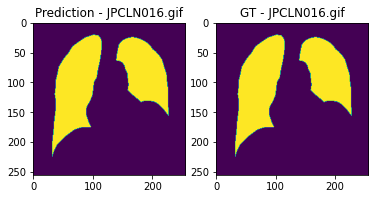

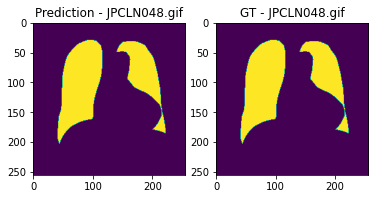

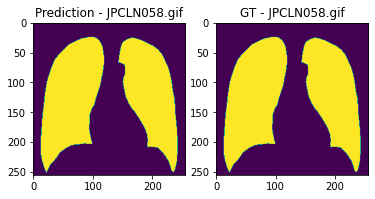

In [28]:
idx_list = ['JPCLN016.gif', 'JPCLN048.gif', 'JPCLN058.gif']
im_array_custom = np.stack([np.array(Image.open(image_path+name[:-3]+"bmp").convert('L')) for name in idx_list], 0)
mask_array_custom = np.stack([get_joint_mask(name, test_masks_path) for name in idx_list], 0)
im_array_custom = np.expand_dims(im_array_custom, axis=3)
mask_array_custom = np.expand_dims(mask_array_custom, axis=3)
mask_array_custom[mask_array_custom < 225.0] = 0.0
mask_array_custom[mask_array_custom >= 225.0] = 1.0

custom_test_dataset = ImageDataset(im_array_custom, mask_array_custom, val_transform)

custom_test_loader = DataLoader(
        custom_test_dataset,
        batch_size=1,
        num_workers=0,
        pin_memory=True,
        shuffle=False)
custom_test_loader = DeviceDataLoader(custom_test_loader, device)

pred_folder = './predictions'
model.eval()
for idx, (x, y) in enumerate(custom_test_loader):
    x = x.to(device=device)
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()
    torchvision.utils.save_image(
        preds, f"{pred_folder}/CustomPred_{idx}.png"
    )
    torchvision.utils.save_image(y, f"{pred_folder}/CustomGT{idx}.png")

model.train()

scores, avg = getDiceScores(custom_test_loader, model)
print(f"Dice scores for custom images: {scores}")

preds = [np.array(Image.open(f"./predictions/CustomPred_{name}.png").convert('L')) for name in range(len(idx_list))]
GTs = [np.array(Image.open(f"./predictions/CustomGT{name}.png").convert('L')) for name in range(len(idx_list))]

for i, name in enumerate(idx_list):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(preds[i])
    ax1.set_title(f"Prediction - {name}")
    ax1.imshow(GTs[i])
    ax2.set_title(f"GT - {name}")
    ax2.imshow(GTs[i])
    fig.show()